# Assignment 1 - Propagation Settings

In [1]:
''' 
Copyright (c) 2010-2020, Delft University of Technology
All rigths reserved

This file is part of the Tudat. Redistribution and use in source and 
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.
'''

import numpy as np
from tudatpy import elements
from tudatpy.io import save2txt
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice_interface
from tudatpy.kernel.simulation import environment_setup
from tudatpy.kernel.simulation import propagation_setup
from matplotlib import pyplot as plt

In [2]:
# # student number: 1244779 --> 1244ABC
A = 7
B = 2
C = 6

simulation_start_epoch = 33.15 * constants.JULIAN_YEAR + A * 7.0 * constants.JULIAN_DAY + \
                            B * constants.JULIAN_DAY + C * constants.JULIAN_DAY / 24.0
simulation_end_epoch = simulation_start_epoch + 344.0 * constants.JULIAN_DAY / 24.0

## Create environment, vehicle, accelerations, and propagation settings

In [3]:
###########################################################################
# CREATE ENVIRONMENT ######################################################
###########################################################################

# Load spice kernels.
spice_interface.load_standard_kernels()

# Create settings for celestial bodies
bodies_to_create = ["Ganymede"]
global_frame_origin = "Ganymede"
global_frame_orientation = "ECLIPJ2000"
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Add Ganymede exponential atmosphere
density_scale_height = 40.0E3
density_at_zero_altitude = 2.0E-9
body_settings.get( "Ganymede" ).atmosphere_settings = environment_setup.atmosphere.exponential( 
        density_scale_height, density_at_zero_altitude)

bodies = environment_setup.create_system_of_bodies(body_settings)

###########################################################################
# CREATE VEHICLE ##########################################################
###########################################################################

# Create vehicle object
bodies.create_empty_body( "JUICE" )

# Set mass of vehicle
bodies.get_body( "JUICE" ).set_constant_mass(2000.0)
    
# Create aerodynamic coefficients interface
reference_area = 100.0
drag_coefficient = 1.2
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
        reference_area,[drag_coefficient,0,0] )
environment_setup.add_aerodynamic_coefficient_interface(
                bodies, "JUICE", aero_coefficient_settings )

###########################################################################
# CREATE ACCELERATIONS ####################################################
###########################################################################

# Define bodies that are propagated, and their central bodies of propagation.
bodies_to_propagate = ["JUICE"]
central_bodies = ["Ganymede"]

# Define accelerations acting on vehicle.
acceleration_settings_on_vehicle = dict(
    Ganymede = 
    [
        propagation_setup.acceleration.spherical_harmonic_gravity(2,2),
        propagation_setup.acceleration.aerodynamic()
    ]
)

# Create global accelerations dictionary.
acceleration_settings = {"JUICE": acceleration_settings_on_vehicle}

# Create acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
        bodies, acceleration_settings, bodies_to_propagate, central_bodies)


###########################################################################
# CREATE PROPAGATION SETTINGS #############################################
###########################################################################

# Define initial state.
system_initial_state = spice_interface.get_body_cartesian_state_at_epoch(
    target_body_name="JUICE",
    observer_body_name="Ganymede",
    reference_frame_name="ECLIPJ2000",
    aberration_corrections="NONE",
    ephemeris_time= simulation_start_epoch )

dependent_variables_to_save = [
    propagation_setup.dependent_variable.keplerian_state(
        "JUICE", "Ganymede")
    ]

# Create propagation settings.
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    system_initial_state,
    simulation_end_epoch,
    output_variables = dependent_variables_to_save
)
    
# Create numerical integrator settings.
fixed_step_size = 10.0
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    simulation_start_epoch,
    fixed_step_size
)

## Propagate Orbit

In [4]:
# Create simulation object and propagate dynamics.
dynamics_simulator = propagation_setup.SingleArcDynamicsSimulator(
    bodies, integrator_settings, propagator_settings, True)

simulation_result = dynamics_simulator.state_history
dependent_variables = dynamics_simulator.dependent_variable_history

## Print final propagation time and state

In [5]:
###########################################################################
# PRINT FINAL PROPAGATION TIME AND STATE ##################################
###########################################################################

final_time_step=list(simulation_result.keys())[-1]
first_time_step=list(simulation_result.keys())[0]

print(
    f"""
JUICE Propagation Results.

Final propagation time of JUICE [s]: {simulation_end_epoch}
Final Cartesian state of JUICE is [m]: \n{
    simulation_result[final_time_step][:]}

    """
)




JUICE Propagation Results.

Final propagation time of JUICE [s]: 1051800840.0
Final Cartesian state of JUICE is [m]: 
[-2.16029721e+06 -8.30475796e+05  2.08120627e+06  9.57302891e+02
  7.83864341e+02  1.29018380e+03]

    


## Save Results

In [6]:
###########################################################################
# SAVE RESULTS ############################################################
###########################################################################

save2txt(solution=simulation_result,
         filename="JUICEPropagationHistory_Q1.dat",
         directory="./",  # default = "./" 
         column_names=None,  # default = None 
         )

save2txt(solution=dependent_variables,
         filename="JUICEPropagationHistory_DependentVariables_Q1.dat",
         directory="./",  # default = "./" 
         column_names=None,  # default = None 
        )

lines = ['\n']*11 

q_n = 1 #question number

with open('cartesian_results_AE4868_2020_A1_5382726.txt','r') as f:
    file_lines = f.readlines()

for i, file_line in enumerate(file_lines):
    lines[i] = file_line

line = f'{simulation_end_epoch}'
for item in simulation_result[final_time_step][:]:
    line = ' '.join((line,str(item)))
line += '\n'

lines[q_n-1] = line
with open('cartesian_results_AE4868_2020_A1_5382726.txt','w') as f:
    f.writelines(lines)

## Plot Results

For inspiration see: 

https://tudat-space.readthedocs.io/en/latest/_src_first_steps/simulations/example_application_2.html#visualize-results

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


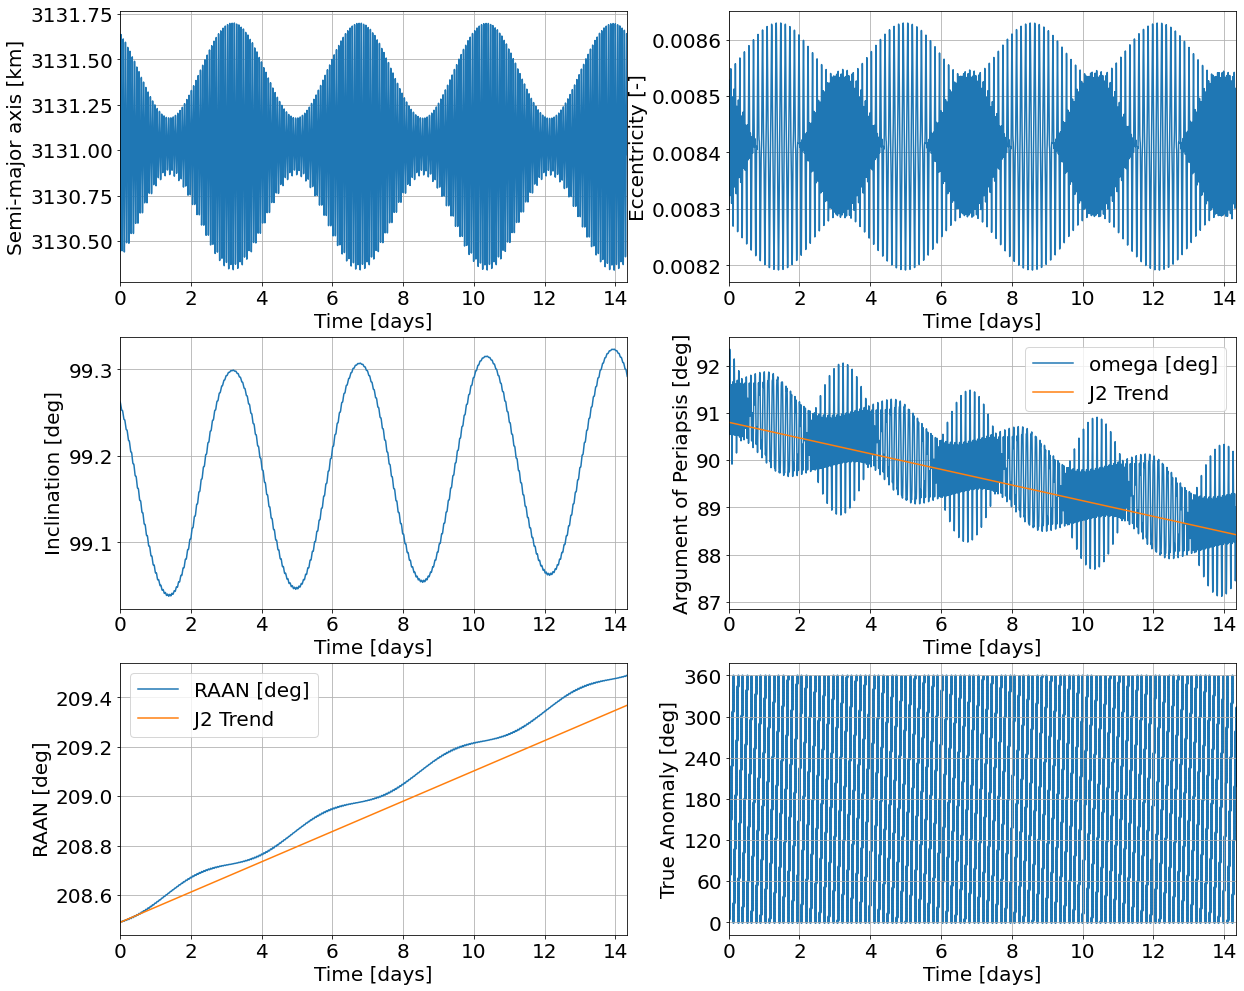

In [7]:
###########################################################################
# PLOT RESULTS ############################################################
###########################################################################

# Extract time and Kepler elements from dependent variables
kepler_elements = np.vstack(list(dependent_variables.values()))
                            
# Kepler Elements
# 0: semi-major axis
# 1: eccentricity
# 2: inclination
# 3: argument of periapsis
# 4: right ascension of the ascending node
# 5: true anomaly

time = dependent_variables.keys()
time_days = [ t / constants.JULIAN_DAY - simulation_start_epoch / constants.JULIAN_DAY for t in time ]

ganymede_gravitational_parameter = body_settings.get( "Ganymede" ).gravity_field_settings.get_gravitational_parameter( )
ganymede_normalized_c20 = body_settings.get( "Ganymede" ).gravity_field_settings.get_cosine_coefficients( )[2,0]
ganymede_reference_radius = body_settings.get( "Ganymede" ).gravity_field_settings.get_reference_radius( )

ganymede_normalized_J2 = -ganymede_normalized_c20*np.sqrt(5)
a = kepler_elements[1,0]
i = kepler_elements[1,2]
e = kepler_elements[1,1]

#trends due to J2 perturbation
raan_J2 = (-3/2)*ganymede_normalized_J2*((ganymede_reference_radius/(a*(1-e**2)))**2)*np.sqrt(ganymede_gravitational_parameter/a**3)*np.cos(i)*constants.JULIAN_DAY

omega_J2 = (3/4)*ganymede_normalized_J2*((ganymede_reference_radius/(a*(1-e**2)))**2)*np.sqrt(ganymede_gravitational_parameter/a**3)*(4-5*np.sin(i)**2)*constants.JULIAN_DAY

# Set font size of figures
font_size = 20
                            
plt.rcParams.update({'font.size': font_size}) 

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots( 3, 2, figsize = (20,17) )
# Semi-major Axis
semi_major_axis = [ element/1000 for element in kepler_elements[:,0] ]
ax1.plot( time_days, semi_major_axis )
ax1.set_ylabel( 'Semi-major axis [km]' )

# Eccentricity
eccentricity = kepler_elements[:,1]
ax2.plot( time_days, eccentricity )
ax2.set_ylabel( 'Eccentricity [-]' )

# Inclination
inclination = [ np.rad2deg( element ) for element in kepler_elements[:,2] ]
ax3.plot( time_days, inclination )
ax3.set_ylabel( 'Inclination [deg]')

# Argument of Periapsis
argument_of_periapsis = [ np.rad2deg( element ) for element in kepler_elements[:,3] ]
J2_omega = [np.rad2deg(kepler_elements[1,3]) + np.rad2deg(omega_J2)*t for t in time_days]
ax4.plot( time_days, argument_of_periapsis, label= 'omega [deg]' )
ax4.plot( time_days, J2_omega, label= 'J2 Trend' )
ax4.legend()
ax4.set_ylabel( 'Argument of Periapsis [deg]' )

# Right Ascension of the Ascending Node
raan = [ np.rad2deg( element ) for element in kepler_elements[:,4] ]
J2_trend = [np.rad2deg(kepler_elements[1,4]) + np.rad2deg(raan_J2)*t for t in time_days]
ax5.plot( time_days, raan , label= 'RAAN [deg]')
ax5.plot( time_days, J2_trend , label= 'J2 Trend' )
ax5.legend()
ax5.set_ylabel( 'RAAN [deg]' )

# True Anomaly
true_anomaly = [ np.rad2deg( element ) for element in kepler_elements[:,5] ]
ax6.scatter( time_days, true_anomaly, s=1 )
ax6.set_ylabel( 'True Anomaly [deg]' )
ax6.set_yticks(np.arange(0, 361, step=60))

for ax in fig.get_axes():
  ax.set_xlabel('Time [days]')
  ax.set_xlim( [min(time_days), max(time_days)] )
  ax.grid()

fig.savefig( fname = 'kepler_elements.eps', bbox_inches='tight')
fig.savefig( fname = 'kepler_elements.png', bbox_inches='tight', format = 'png')
